In [19]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageColor
import cv2
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import os
from sklearn.cluster import KMeans
import argparse
import imutils
import math 
import io
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pylab as pl
from PIL import Image
import numpy as np
import pylab
from colorsys import rgb_to_hsv

WESE_Path='/Users/rohitganti/Desktop/Research/Luis Research/WSe2/'
Monolayer_Path='/Users/rohitganti/Desktop/Research/Luis Research/WSe2/Potential Monolayers'
Samples_Path='/Users/rohitganti/Desktop/Research/Luis Research/WSe2/Usable Samples'

WESE_Array=[]
for items in os.listdir(WESE_Path):
    if items[-4:-1]=='.jp':
        WESE_Array.append(WESE_Path+items)
    
Monolayer_Array=[]
for items in os.listdir(Monolayer_Path):
    Monolayer_Array.append(Monolayer_Path+ items)

Sample_Array=[]
for items in os.listdir(Samples_Path):
    Sample_Array.append(Samples_Path+items)

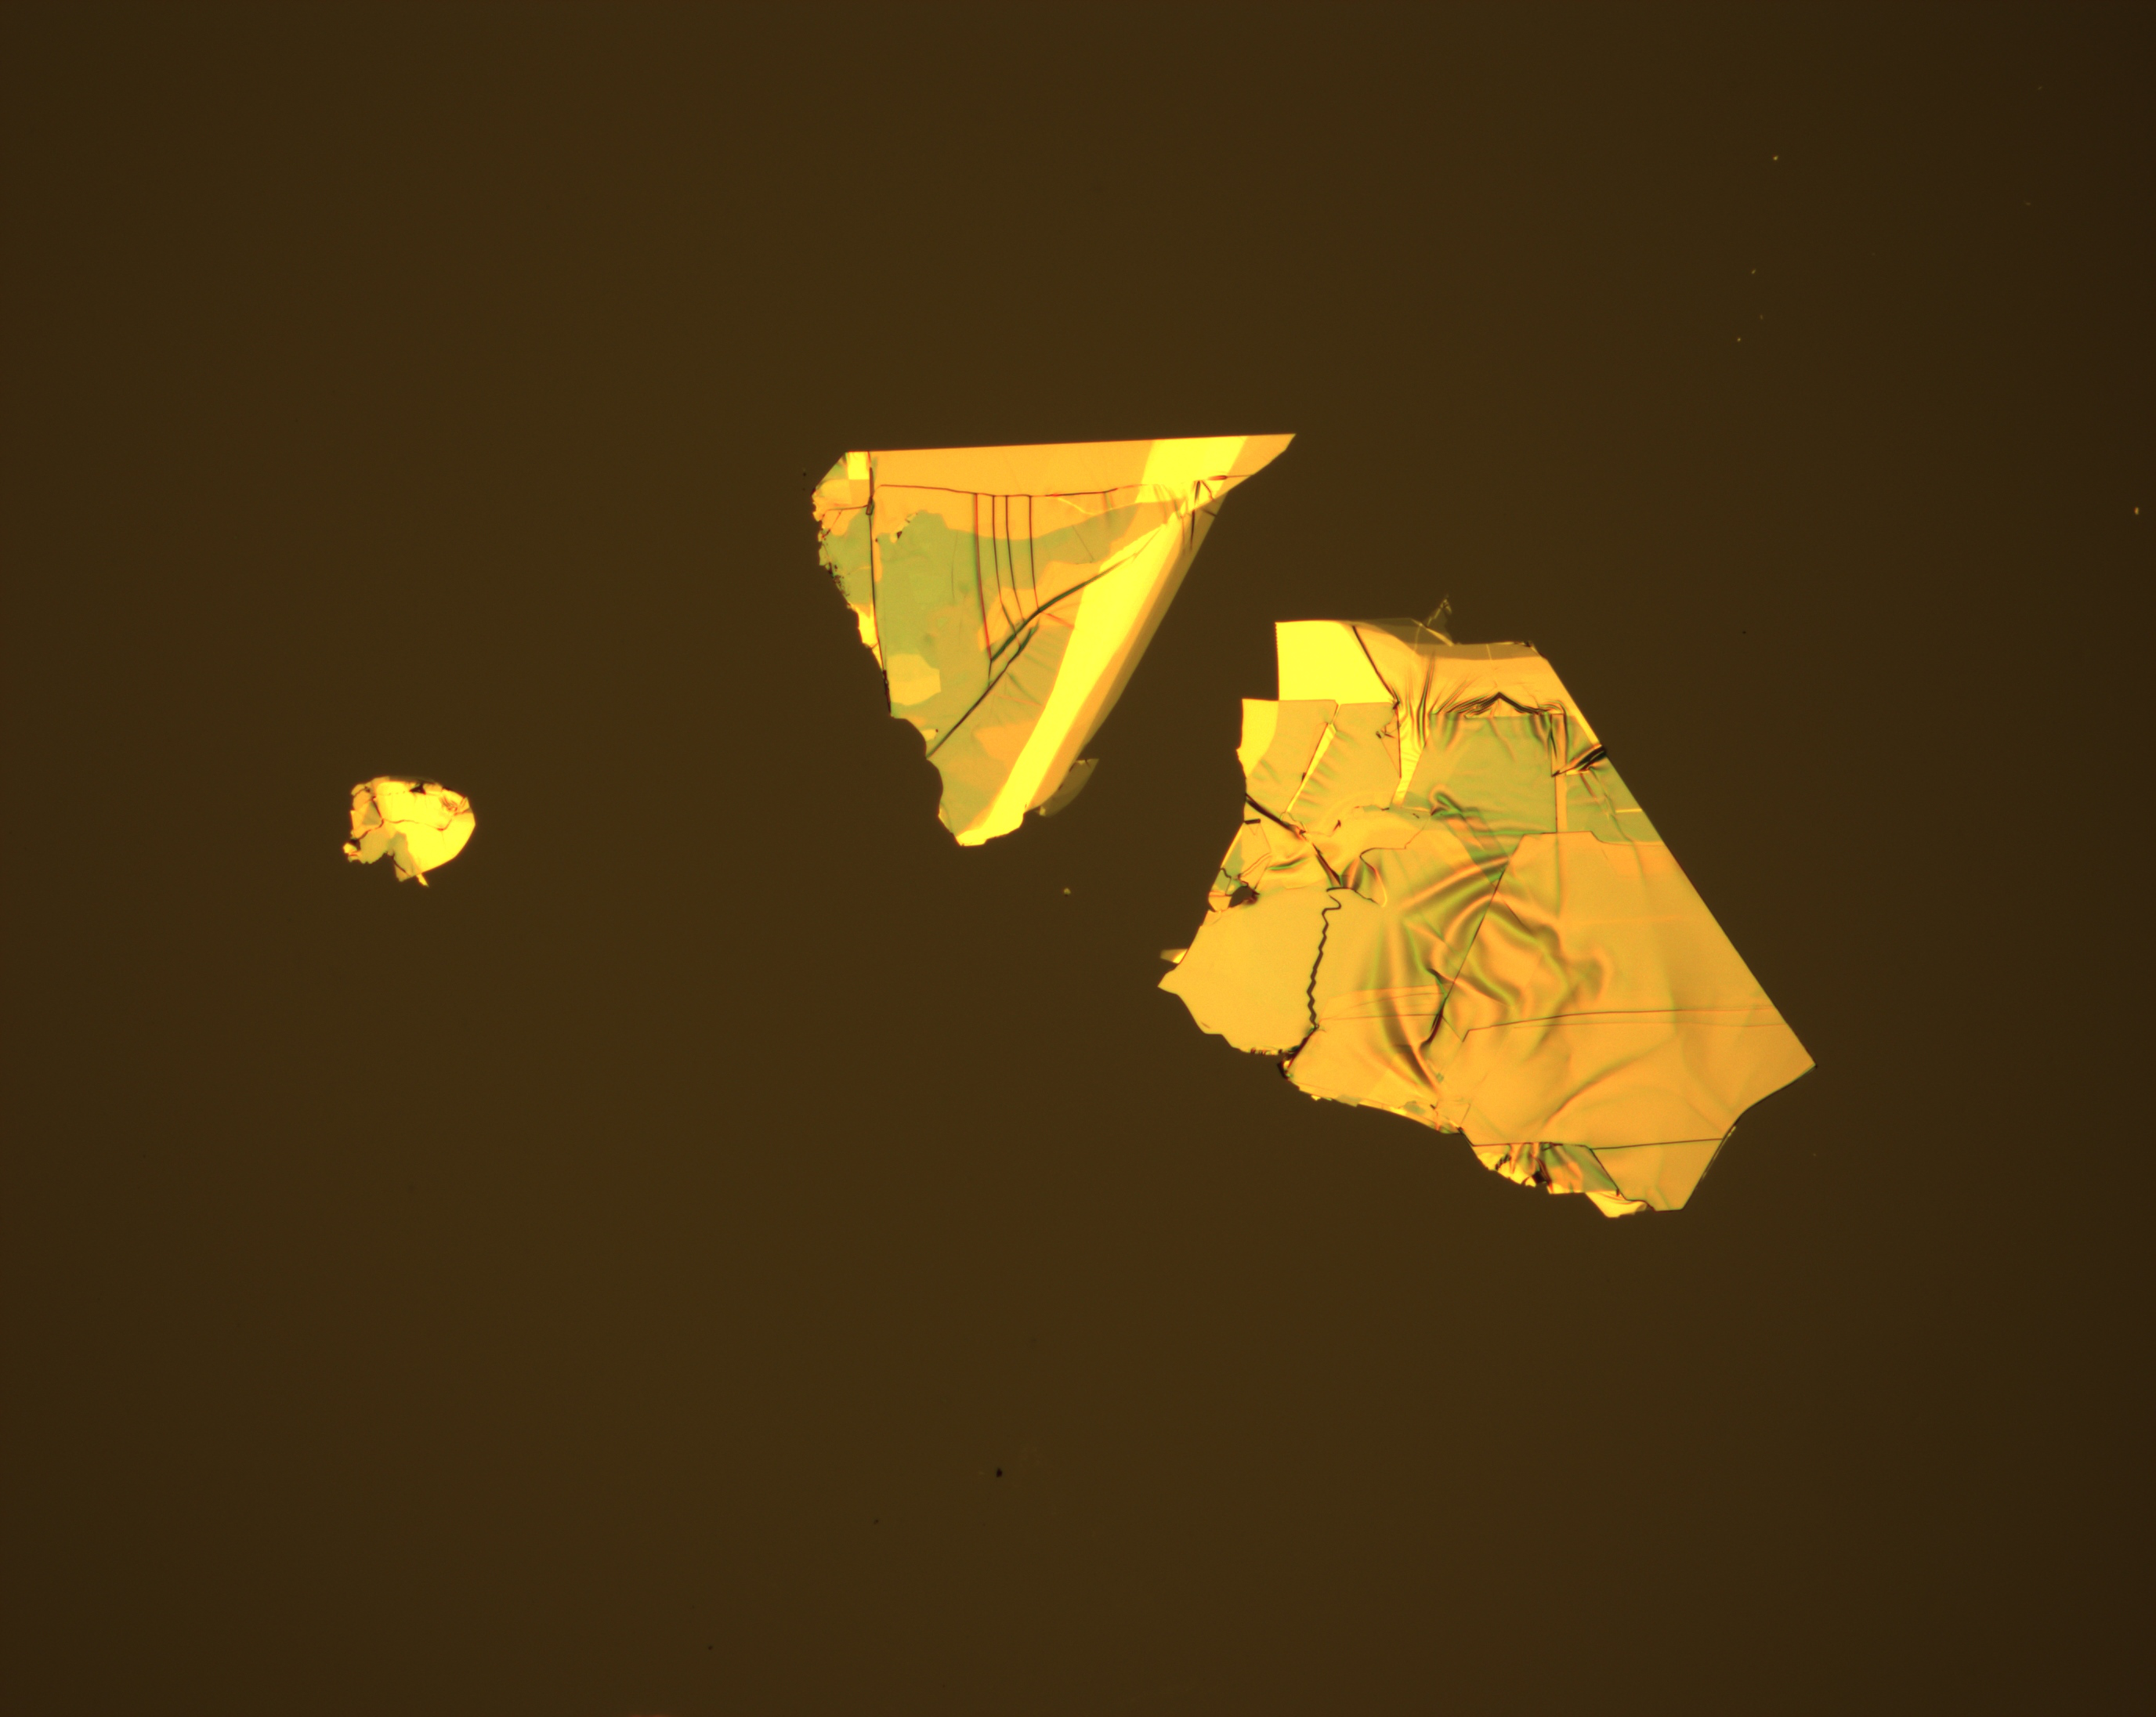

In [77]:
image_number= WESE_Array[12]
a=Image.open(image_number)
a

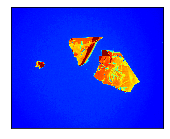

In [78]:
img = Image.open(image_number).convert('L')
z   = np.asarray(img)
mydata = z[::1,::1]
fig = pl.figure(facecolor='w')
ax1 = fig.add_subplot(1,2,1)
im = ax1.imshow(mydata,interpolation='nearest',cmap=pl.cm.jet)
#ax1.set_title('2D')
pl.xticks([])
plt.yticks([])
pl.show()

In [63]:
def fig2img(fig):
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

def fig2data(fig):
    fig.canvas.draw()
    w,h = fig.canvas.get_width_height()
    buf = np.fromstring(fig.canvas.tostring_argb(), dtype=np.uint8)
    buf.shape = (w,h,4)
    buf = np.roll(buf,3,axis=2)
    return buf

def fig2img2(fig):
    buf = fig2data(fig )
    w, h, d = buf.shape
    return Image.frombytes("RGBA", (w,h), buf.tostring( ) )

In [24]:
b=fig2img(fig)

### Pre Processing of image and imported functions

In [25]:
def count_pixels(filename):
    color_count = {}
    with Image.open(filename) as image:
        width, height = image.size
        rgb_image = image.convert('RGB')
        for x in range(width):
            for y in range(height):
                rgb = rgb_image.getpixel((x, y))
                if rgb in color_count:
                    color_count[rgb] += 1
                else:
                    color_count[rgb] = 1
    color_array=[]
    for colors in color_count:
        color_array.append(colors)
    return color_count, color_array

def get_max(color_dict,color_array):
    """Returns the color value with the most number of pixes or the set background """
    new_max= color_dict[color_array[0]]
    color=color_array[0]
    for colors in color_dict:
        if int(color_dict[colors])> int(new_max):
            new_max= color_dict[colors]
            color= colors
    return color

def average_tuple(nums):
    result = [sum(x) / len(x) for x in zip(*nums)]
    tup_down= (math.floor(result[0]), math.floor(result[1]), math.floor(result[2]))
    tup_up= (math.ceil(result[0]), math.ceil(result[1]), math.ceil(result[2]))
    return tup_down, tup_up

def get_possible_backgrounds(color_dict, color_array):
    """Returns the five backgrounds"""
    new_dict= color_dict.copy()
    first_back= get_max(new_dict, color_array)
    new_dict.pop(first_back)
    color_array.remove(first_back)
    second_back= get_max(new_dict, color_array)
    new_dict.pop(second_back)
    color_array.remove(second_back)
    third_back= get_max(new_dict, color_array)
    new_dict.pop(third_back)
    color_array.remove(third_back)
    fourth_back= get_max(new_dict,color_array)
    new_dict.pop(fourth_back)
    color_array.remove(fourth_back)
    fifth_back= get_max(new_dict, color_array)
    new_dict.pop(fifth_back)
    color_array.remove(fifth_back)
    all_tuples= first_back, second_back, third_back, fourth_back, fifth_back
    #total_similar_pixels= color_dict[first_back]+color_dict[second_back]+color_dict[third_back]+color_dict[fourth_back]+color_dict[fifth_back]
    return first_back,second_back,third_back,fourth_back,fifth_back

In [26]:
c=b.resize(a.size)
c.save('file.jpg')

In [27]:
color_dict, color_array= count_pixels('file.jpg')
color_dict= dict(color_dict)

In [28]:
get_possible_backgrounds(color_dict,color_array)

((255, 255, 255), (0, 0, 182), (2, 0, 172), (0, 1, 174), (0, 1, 180))

### Get the Single Layer Pixels identification

In [29]:
# all blues have 255

In [30]:
# only have the blue pixels or their related shades for identifying the single layers potentials
blue_dict={}
threshold=10
for col in color_dict:
    if col[2]== 255 or col[2]==205:
        if col[1]>= 190- threshold or col[1]<= 190+threshold:
            blue_dict[col]= color_dict[col]

blue_dict1={}
restrict=[i for i in range(200,255)]
for col in blue_dict:
    if col[0] not in restrict:
        blue_dict1[col]= blue_dict[col]
blue_dict1

{(255, 255, 255): 5098459,
 (255, 254, 255): 3636,
 (255, 253, 255): 1946,
 (255, 252, 255): 694,
 (255, 251, 255): 391,
 (255, 241, 255): 1,
 (255, 248, 255): 16,
 (255, 244, 255): 6,
 (255, 238, 255): 1,
 (255, 240, 255): 2,
 (255, 250, 255): 307,
 (255, 249, 255): 87,
 (255, 245, 255): 2,
 (255, 247, 255): 3,
 (255, 246, 255): 5,
 (255, 243, 255): 1,
 (255, 239, 255): 2,
 (0, 237, 255): 4,
 (0, 221, 255): 1,
 (0, 230, 255): 5,
 (8, 236, 255): 1,
 (38, 217, 255): 1,
 (8, 0, 205): 14,
 (7, 0, 205): 6,
 (4, 233, 255): 1,
 (64, 214, 255): 1,
 (0, 227, 255): 4,
 (22, 226, 255): 1,
 (48, 205, 255): 1,
 (0, 0, 205): 141,
 (0, 245, 255): 2,
 (0, 231, 255): 6,
 (39, 203, 255): 1,
 (0, 240, 255): 2,
 (0, 228, 255): 6,
 (0, 236, 255): 3,
 (40, 195, 255): 1,
 (11, 215, 255): 1,
 (1, 218, 255): 2,
 (39, 219, 255): 1,
 (14, 218, 255): 1,
 (6, 206, 255): 3,
 (42, 163, 255): 1,
 (14, 6, 205): 1,
 (121, 216, 255): 1,
 (124, 238, 255): 1,
 (8, 1, 205): 1,
 (0, 13, 255): 6,
 (0, 8, 255): 9,
 (0, 16, 2

In [31]:
layers= {
    (0,0,255): 'background blue 1',
    (51,51,255): 'background blue 2',
    (0,0,204): 'background blue 3',
    (0,128,255): 'layer 1',
    (0,102,204): 'layer 1 (2)',
    (51,153,255): 'layer 2',
    (102,178,255): 'layer 3',
    (153,204,255): 'layer 3 (2)',
    (0,255,255): 'layer 4',
    (51,255,255): 'layer 4 (1)',
    (102,255,255): 'layer 5',
    (153,255,255): 'layer 5(1)',
    (255,255,255): 'White background'
}

colors=layers
def to_hsv (color):
    "" "converts color tuples to floats and then to hsv" ""
    return rgb_to_hsv (* [x/255.0 for x in color]) #rgb_to_hsv wants floats!

def color_dist (c1, c2):
    "" "returns the squared euklidian distance between two color vectors in hsv space" ""
    return sum ((a-b) ** 2 for a, b in zip (to_hsv (c1), to_hsv (c2)))

def min_color_diff (color_to_match, colors):
    "" "returns the` (distance, color_name) `with the minimal distance to` colors` "" "
    return min ((color_dist (color_to_match, test), colors[test]) for test in colors)

for color_to_match in blue_dict:
    print(min_color_diff (color_to_match, colors))

(0.0, 'White background')
(0.15072664359861596, 'layer 5(1)')
(0.15687812379853905, 'layer 5(1)')
(0.21937812379853905, 'layer 3 (2)')
(0.2162870049980777, 'layer 3 (2)')
(0.21322664359861596, 'layer 3 (2)')
(0.21019703960015376, 'layer 3 (2)')
(0.14173010380622836, 'layer 5(1)')
(0.14769703960015376, 'layer 5(1)')
(0.1387927720107651, 'layer 5(1)')
(0.18159265667051133, 'layer 3 (2)')
(0.2012927720107651, 'layer 3 (2)')
(0.13016532103037298, 'layer 5(1)')
(0.13588619761630144, 'layer 5(1)')
(0.15149824853688756, 'layer 3 (2)')
(0.18985101883890815, 'layer 3 (2)')
(0.17361111111111113, 'layer 3 (2)')
(0.17890138408304498, 'layer 3 (2)')
(0.18853528557392457, 'layer 3 (2)')
(0.20719819300269127, 'layer 3 (2)')
(0.15149824853688756, 'layer 3 (2)')
(0.14943315071126484, 'layer 5(1)')
(0.16382256824298347, 'layer 3 (2)')
(0.20423010380622836, 'layer 3 (2)')
(0.19266532103037298, 'layer 3 (2)')
(0.12735101883890815, 'layer 5(1)')
(0.12181468665897731, 'layer 5(1)')
(0.19838619761630144, 'la

(0.0006294859465159388, 'layer 1')
(0.00011406222583741829, 'layer 1')
(0.009002872034605737, 'background blue 1')
(0.0014222439354424563, 'layer 1')
(0.0021125739802004082, 'layer 1')
(0.010451847442709609, 'background blue 1')
(0.0037429245466831557, 'background blue 1')
(0.002294321747096327, 'layer 1')
(0.0001627053993139976, 'layer 1')
(0.0011868749626212172, 'layer 1')
(0.0003409405597058864, 'layer 1')
(0.0016721798708220635, 'layer 1')
(0.0012020111816292596, 'layer 1')
(0.0006077279166802383, 'layer 1')
(0.0012347839135657655, 'layer 1')
(0.004276755260622351, 'layer 1')
(0.0007671503852187566, 'layer 1')
(0.0005822223192056881, 'layer 1')
(0.005196318723567857, 'background blue 1')
(0.0011462615036418572, 'layer 1')
(0.0010711876563660725, 'layer 1')
(0.004677497059176092, 'layer 1')
(0.003795739036846932, 'layer 1')
(8.280300510759742e-05, 'layer 1')
(6.195217908507245e-05, 'layer 1')
(0.003349097459960017, 'layer 1')
(0.00038988149856892813, 'layer 1')
(0.001070393322178481

In [32]:
print(min_color_diff((0,255,255),colors))

(0.0, 'layer 4')


In [33]:
color_to_match= (0,255,255)
min_color_diff(color_to_match, colors)

(0.0, 'layer 4')

In [34]:
imag= cv2.imread(image_number,cv2.IMREAD_COLOR)
b,g,r = cv2.split(imag)
image=cv2.merge([r,g,b])
laplacian = cv2.Laplacian(image,cv2.CV_64F)
sobelx = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


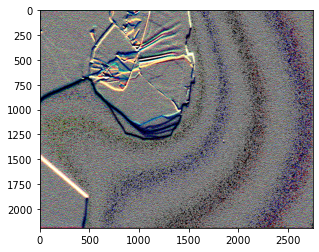

In [35]:
plt.imshow(sobely,cmap = 'gray')
plt.show()

In [53]:
def draw_edges(image):
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(grayscale, 30, 100)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 60, np.array([]), 50, 5)
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), (20, 220, 20), 3)
    plt.imshow(image)
    plt.show()

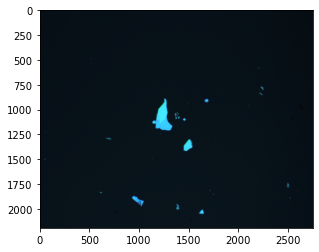

In [59]:
image_number= WESE_Array[7]
image= cv2.imread(image_number)
grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(grayscale, 30, 100)
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 60, np.array([]), 50, 5)
for line in lines:
    for x1, y1, x2, y2 in line:
        cv2.line(image, (x1, y1), (x2, y2), (20, 220, 20), 3)
plt.imshow(image)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


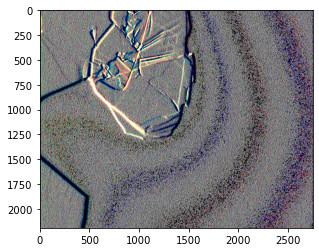

In [57]:
plt.imshow(sobelx)